# setup

In [1]:
from ecgprep import preprocess, read_ecg
import argparse
import h5py
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
input_file = 'RECORDS.txt'
root_dir = 'WFDB_ShaoxingUniv'
out_file = 'ningbo.h5'

fmt = 'wfdb'

new_freq = 400
new_len = 4096
scale = 2
use_all_leads = True
remove_baseline = False
remove_powerline = None

# before

In [3]:
all_leads = ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [4]:
files = pd.read_csv(input_file, header=None).values.flatten()
folder = root_dir
# n = len(files)
n = len(files) - 97 # from reproducao_nan.ipynb

In [5]:
for i, f in enumerate(tqdm.tqdm(files)):
    break
i, f

  0%|          | 0/45152 [00:00<?, ?it/s]


(0, 'JS00001')

In [6]:
ecg, sample_rate, leads = read_ecg.read_ecg(os.path.join(folder, f), format = fmt)
ecg, sample_rate, leads

(array([[-0.254, -0.254, -0.254, ..., -0.034,  0.024,  0.005],
        [ 0.264,  0.264,  0.264, ..., -0.068, -0.049, -0.034],
        [ 0.517,  0.517,  0.517, ..., -0.034, -0.073, -0.039],
        ...,
        [ 0.81 ,  0.81 ,  0.81 , ..., -0.205, -0.2  , -0.171],
        [ 0.81 ,  0.81 ,  0.81 , ..., -0.2  , -0.195, -0.166],
        [ 0.527,  0.527,  0.527, ...,  0.102,  0.093,  0.112]]),
 500,
 ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

In [7]:
ecg_preprocessed, new_rate, new_leads = preprocess.preprocess_ecg(ecg, sample_rate, all_leads, # different lead names
                                                                          new_freq=new_freq,
                                                                          new_len=new_len,
                                                                          scale=scale,
                                                                          use_all_leads=use_all_leads,
                                                                          remove_baseline=remove_baseline,
                                                                          remove_powerline=remove_powerline)
ecg_preprocessed, new_rate, new_leads

(array([[-0.45662999, -0.52572182, -0.49735178, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.47596687,  0.54495072,  0.52134413, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.93259686,  1.07067254,  1.01869592, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 1.46068218,  1.67124455,  1.60023106, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.46065339,  1.67128349,  1.60013837, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.94859643,  1.09061578,  1.03516844, ...,  0.        ,
          0.        ,  0.        ]]),
 400,
 ['DI',
  'DII',
  'DIII',
  'AVR',
  'AVL',
  'AVF',
  'V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6'])

In [8]:
h5f = h5py.File(out_file, 'w')
x = None

In [9]:
nans = 0
for i, f in enumerate(tqdm.tqdm(files)):
    ecg, sample_rate, leads = read_ecg.read_ecg(os.path.join(folder, f), format=fmt)
    if np.isnan(ecg).any():
        nans += 1
        continue
    ecg_preprocessed, new_rate, new_leads = preprocess.preprocess_ecg(ecg, sample_rate, all_leads, # different lead names
                                                                            new_freq=new_freq,
                                                                            new_len=new_len,
                                                                            scale=scale,
                                                                            use_all_leads=use_all_leads,
                                                                            remove_baseline=remove_baseline,
                                                                            remove_powerline=remove_powerline)
    if x is None:
        n_leads, n_samples = ecg_preprocessed.shape
        x = h5f.create_dataset('tracings', (n, n_samples, n_leads), dtype='f8')
        id = h5f.create_dataset('exam_id', (n,), dtype='i4')
    # x[i, :, :] = ecg_preprocessed.T
    # id[i] = int(f[2:])
    x[i-nans, :, :] = ecg_preprocessed.T
    id[i-nans] = int(f[2:])
assert nans == 97

100%|██████████| 45152/45152 [07:06<00:00, 105.96it/s]


In [10]:
nans

97

In [11]:
int(f[2:]), f

(45551, 'JS45551')

In [13]:
h5f.close()

# after

In [14]:
hdf5_file = h5py.File(out_file, "r")

In [15]:
i = 10581
hdf5_file['tracings'][i].shape, hdf5_file['tracings'][i]

((4096, 12),
 array([[ 0.03836613,  0.17485516,  0.13648903, ..., -0.12369036,
          0.16736568, -0.12146084],
        [ 0.03453467,  0.18110569,  0.14657103, ..., -0.15033084,
          0.19082692, -0.13005651],
        [ 0.01944503,  0.17436404,  0.15491901, ..., -0.14431191,
          0.16878379, -0.12403404],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]))

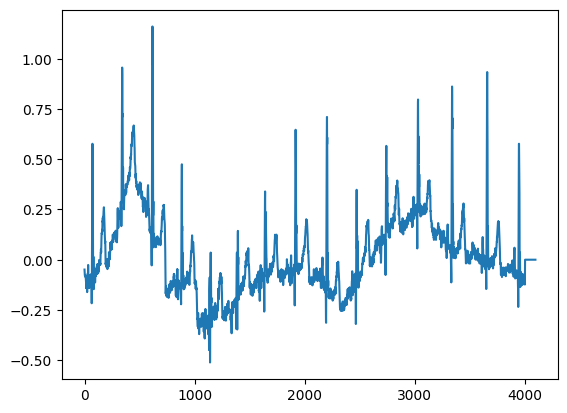

In [20]:
plt.plot(hdf5_file['tracings'][i, :, 4])

In [21]:
hdf5_file.close()